In [10]:
import math
from botorch.models.model import Model
from botorch.utils import t_batch_mode_transform
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import AcquisitionFunction
from botorch.optim.optimize import optimize_acqf
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize

#kernels
from gpytorch.kernels import RBFKernel

problem setting

penicillin function

ouputs:

P 
-t
-CO2

constraints(example):

P >= 12

-t >= -10

-CO2 >= -100

In [11]:
from botorch.test_functions.multi_objective import Penicillin

test_f = Penicillin(negate= True)

#initialize data
n= 10
random_tensor = torch.zeros((n, 7), dtype= torch.float64)

for i in range(7):
    lower_bound = test_f.bounds[0, i]
    upper_bound = test_f.bounds[1, i]
    random_tensor[:, i] = lower_bound + (upper_bound - lower_bound) * torch.rand(n)

train_X = normalize(random_tensor, test_f.bounds)
train_Y = test_f(random_tensor)
train_Y = train_Y.to(train_X)

acquisition

In [12]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.max(torch.zeros_like(u_t), u_t / self.theta) ** m, dim=-1)[0]  # b

        return scalarized_ut


Auxiliary Acq

In [13]:
class AuxiliaryAcq(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        An auxiliary acquisition defined in Algo.2

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(MCAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform()
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        #print(posterior.mean.shape)
        means = posterior.mean  # b x q x o
        std_devs = posterior.variance.sqrt()  # b x q x o
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x qx o
        #print('233', u_t.shape)

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.min(u_t, dim=-1)[0], dim=-1)[0]  # b
        return scalarized_ut


constraints

In [14]:
import torch
from typing import List, Tuple, Callable

def create_ucb_constraints(model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """
    
    def constraint(X):
        """
        Evaluates all constraints for a batch of design points.

        Args:
            X (torch.Tensor): A tensor of shape [q, d] (where `d` is the dimension of the input space and `q` can be 1 or more 
                              representing different design points).

        Returns:
            torch.Tensor: A tensor of shape [q, m] (where `m` is the number of output dimensions) containing the evaluated 
                          constraints.
        """
        # Compute posterior at X
        X = X.unsqueeze(0)
        posterior = model.posterior(X)
        mean = posterior.mean
        variance = posterior.variance
        ucb = mean + beta * variance.sqrt()  # Compute the UCB

        # Evaluate all constraints and return the difference from thresholds
        return ucb - thresholds

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [(lambda X, i=i: constraint(X)[:, i], True) for i in range(thresholds.size(0))]

    return constraints


In [15]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

BO loop

take thresholds to be: 8 , -60, -350

kernel picking

In [16]:
from Customized_Kernels import Customized_RBF, Customized_Matern

rbf_module = Customized_RBF(2,2)
matern_module = Customized_Matern(1,0.5,1)

In [17]:
import warnings
from metrics import HV
warnings.filterwarnings('ignore')
import time
beta = 3
thresholds = torch.tensor([8, -60, -350], dtype= torch.float64)
Hpv = []
NUM_ITER = 50
print('-'*NUM_ITER)
for batch in range(NUM_ITER):
    t0 = time.monotonic()
    model_list = []
    m = 3
    for i in range(m):
        current_model = SingleTaskGP(train_X= train_X, train_Y= train_Y[:, i].unsqueeze(-1), outcome_transform= Standardize(m = 1), train_Yvar= torch.zeros((train_X.shape[0],1)) + 0.05**2, covar_module= matern_module)
        model_list.append(current_model)
    model = ModelListGP(*model_list)
    #t1 = time.monotonic()
    #sample theta from distribution
    theta = get_random_sample_on_n_sphere(m,1).abs()

    #auxiliary acquisition
    AuxAcq = AuxiliaryAcq(model= model, beta= torch.tensor(beta), theta = theta, ref= thresholds)
    initializer, acq_value = optimize_acqf(
        acq_function = AuxAcq,
        q = 5,
        num_restarts = 1,
        raw_samples = 1,
        bounds = torch.tensor([[0.0]*7, [1.0]*7]),
        options = {'maxiter':5}
    )
    #declare
    if acq_value < 0: 
        print(f'decalre infeasibility in {batch+1} rounds')
        break
    #t2 = time.monotonic()
    #create acquisition function
    HVUCB = HyperVolumeScalarizedUCB(model= model, beta= torch.tensor(beta), theta = theta, ref= thresholds)
    #optimize constraint function
    candidate, _ = optimize_acqf(
        acq_function = HVUCB,
        q = 1,
        num_restarts = 5,
        nonlinear_inequality_constraints = create_ucb_constraints(beta=beta, model= model, thresholds= thresholds),
        #ic_generator = gen_batch_initial_conditions,
        batch_initial_conditions = initializer.view([-1,1,7]),
        #take the standard bounds
        bounds = torch.tensor([[0.0]*7, [1.0]*7]),
        options = {'maxiter':50}
    )
    #t3 = time.monotonic()
    #update data
    train_X = torch.cat([train_X, candidate],dim=0)
    train_Y = torch.cat([train_Y, test_f(unnormalize(candidate, bounds= test_f.bounds))], dim = 0)
    Hpv.append(HV(Y = train_Y, ref = thresholds))
    #print(t1-t0, t2-t1, t3-t2)
    #t4 = time.monotonic()
    print('-', end= '')
    #print(t1-t0,t2-t1,t3-t2,t4-t3)

--------------------------------------------------


--------------------------------------------------

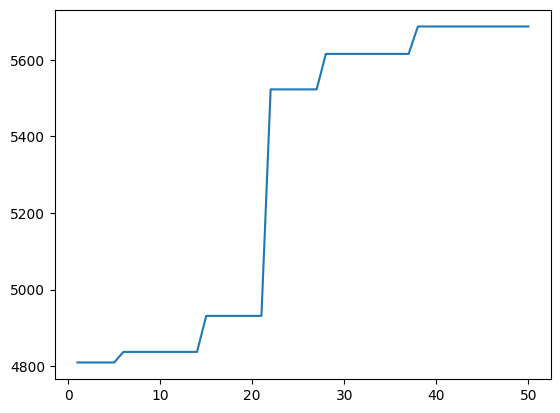

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(Hpv)+1), Hpv)